# Automatic Dataset Generation From CAD for Vision-Based Grasping

This script demonstrates the generation of a synthetic dataset of a multi-object scenario using CAD files.

The dataset consists of the followinf data :

- RGB images 
- Depth Images
- Pose information
- Binary Mask 

---
Please include the following citation of our [paper](https://ieeexplore.ieee.org/abstract/document/9659336), if you use this work in your publications

```
@INPROCEEDINGS{9659336,
  author={Ahmad, Saad and Samarawickrama, Kulunu and Rahtu, Esa and Pieters, Roel},
  booktitle={2021 20th International Conference on Advanced Robotics (ICAR)}, 
  title={Automatic Dataset Generation From CAD for Vision-Based Grasping}, 
  year={2021},
  volume={},
  number={},
  pages={715-721},
  doi={10.1109/ICAR53236.2021.9659336}}
```

### Installation

Please make sure to follow the [installation](https://github.com/KulunuOS/gazebo_dataset_generation#installation) from the github repository before running the notebook. Remember to change your jupyter notebook kernel to "open3d".

### 1. Initialization

 1. Run the gazebo world in a new terminal `$ roslaunch data_generation metrics.launch` 
 2. Import the required modules by running the code block below 


In [1]:
import sys
import numpy as np
import open3d as o3d
import rospy
import tf
from cv_bridge import CvBridge, CvBridgeError
from gazebo_msgs.msg import LinkState as stateGZ
from gazebo_msgs.srv import GetModelState as getStateGZ
from gazebo_msgs.srv import SetLinkState as setStateGZ
from geometry_msgs.msg import (Point, Pose, PoseArray, PoseStamped, Quaternion,
                               Twist, Vector3)
from rospy.exceptions import ROSException
from scipy.spatial.transform import Rotation as R
from sensor_msgs.msg import CameraInfo, Image, PointCloud2
from matplotlib.pyplot import imshow

import copy
import time
import cv2
import scipy.io as sio
import os
import argparse
import ipywidgets as wgt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-01-28 13:14:14,841 - topics - topicmanager initialized


 3. Create the directories if they donot already exist 

In [2]:
#%% Create the directories
#rospy.signal_shutdown("done ")
if not os.path.exists('rgb'):
    os.makedirs('rgb')
if not os.path.exists('depth'):
    os.makedirs('depth')
if not os.path.exists('meta'):
    os.makedirs('meta')
if not os.path.exists('mask'):
    os.makedirs('mask')
if not os.path.exists('model_pointcloud'):
    os.makedirs('model_pointcloud') 

 4. Lets pass the two CAD models `bottom_casing` and `left_gear` as arguments to our python script.

In [3]:
#%% Argument parser
parser = argparse.ArgumentParser(description = 'parse some parameters')
parser.add_argument("models", nargs='+', help="Enter the names of the models seperated by a space")
#args = parser.parse_args()
args = parser.parse_args('bottom_casing left_gear'.split())
#args = parser.parse_args('left_gear bottom_casing'.split())
n_models = len(args.models)

5. Initialize the required ros functionalities

In [4]:
rospy.init_node('data_render_gazebo', anonymous = True)
rate = rospy.Rate(0.5)
bridge = CvBridge()
cam_info_msg = rospy.wait_for_message('kinect1/color/camera_info', CameraInfo, timeout = 2)

### 2. Setting camera pose in gazebo

In [5]:
#%% Function to set camera position and pose
def set_cam_state_gazebo(camPos, camTwist):
    # Set cam state in gazebo
    camstate = stateGZ('kinect_ros::link', camPos, camTwist, 'world' )
    print('Transforming camera to pose : '+str(sample_num))
    try:
       gzclient = rospy.ServiceProxy('gazebo/set_link_state', setStateGZ)
       resp = gzclient(camstate)
        
    except Exception as inst:
           print('Error in gazebo/set_link_state service request: ' + str(inst) )
              

 - Explanation on Pose and Twist message
 - Explanation on Eular vs Quaternion

In [6]:
def calc_params(phi,theta,dist):
    theta_rad = np.deg2rad(theta)
    phi_rad = np.deg2rad(phi)
    X = dist*np.cos(phi_rad)*np.cos(theta_rad)
    Y = dist*np.cos(phi_rad)*np.sin(theta_rad)
    Z = np.abs(dist*np.sin(phi_rad)) + 0.84

    cam_euler = R.from_euler('xyz',[0,phi,theta+180], degrees=True)
    cam_quat = cam_euler.as_quat()
    
    camPos = Pose(position= Point(x=X, y=Y, z=Z), 
                  orientation= Quaternion(x=cam_quat[0], y=cam_quat[1] , z=cam_quat[2], w=cam_quat[3]))
    camTwist = Twist(linear= Vector3(x=0, y=0, z=0) , 
                     angular= Vector3(x=0, y=0, z=0))
    
    return camPos,camTwist, X, Y,Z, cam_euler 

In [7]:
def test_cam_state(phi,theta,dist):
     
    camPos,camTwist,_,_,_,_ = calc_params(phi,theta,dist)
    set_cam_state_gazebo(camPos, camTwist)
    
    frame = rospy.wait_for_message('/kinect1/color/image_raw', Image, timeout = 3)
    frame =  bridge.imgmsg_to_cv2(frame, desired_encoding='rgb8')
    imshow(frame)
    
    return 

sample_num = 'test_pose'    
wgt.interact(test_cam_state,
             phi=wgt.IntSlider(min=0, max=90, step=1, value=45),
             theta=wgt.IntSlider(min=0, max=360, step=1, value=45),
             dist= wgt.FloatSlider(min=0, max=1, step=0.01, value=0.25));

interactive(children=(IntSlider(value=45, description='phi', max=90), IntSlider(value=45, description='theta',…

In [8]:
 #%% Function to convert between Image types for depth images
def convert_types(img, orig_min, orig_max, tgt_min, tgt_max, tgt_type):

    #info = np.finfo(img.dtype) # Get the information of the incoming image type
    # normalize the data to 0 - 1
    img_out = img / (orig_max-orig_min)   # Normalize by input range
    img_out = (tgt_max - tgt_min) * img_out # Now scale by the output range
    img_out = img_out.astype(tgt_type)

    #cv2.imshow("Window", img)
    return img_out

In [9]:
def check_dup():
    rgb_duplicate = True                     
    while rgb_duplicate:
        print('Subscribing to rgb topics...')
        img_msg = rospy.wait_for_message('/kinect1/color/image_raw', Image, timeout = 3)
        cv_image = bridge.imgmsg_to_cv2(img_msg, desired_encoding='rgb8')
        #cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

        if sample_num > 0:  
            #No point checking for the sample 0
            previous_im = cv2.imread('rgb/'+str(sample_num-1)+'.png', -1)
            rgb_duplicate = abs(np.mean(cv_image - previous_im)) < 2 # Mean of all pixels shouldn't be this small if it's two different images
            print('rgb diff: '+str(np.mean(cv_image - previous_im)))
            print(rgb_duplicate)
            if rgb_duplicate:
                #Try setting state again. Sometimes gazebo trips out as well.
                set_cam_state_gazebo(camPos, camTwist)

        else:
            rgb_duplicate = False

    depth_duplicate = True 
    while depth_duplicate:
        print('Subscribing to depth topics...')
        depthImg_msg = rospy.wait_for_message('/kinect1/depth/image_raw', Image, timeout = 3 )
        cv_depthImage = bridge.imgmsg_to_cv2(depthImg_msg, desired_encoding='passthrough')
        if sample_num > 0:
            previous_im = cv2.imread('depth/'+str(sample_num-1)+'.png', -1)
            depth_duplicate = abs(np.nanmean(cv_depthImage - previous_im))< 200  # Mean of all pixels shouldn't be this small if it's two different images
            print('depth diff: '+str(np.nanmean(cv_depthImage - previous_im)))# - previous_im)))
            print(depth_duplicate)
            if depth_duplicate:
                #Try setting state again. Sometimes gazebo trips out as well.
                set_cam_state_gazebo(camPos, camTwist)
        else:
            depth_duplicate = False
          
    return cv_image, cv_depthImage

In [10]:
# Get Camera Extrinsics
def get_camera_extrinsics(phi,theta, dist):
    
    _,_,X,Y,Z,_ = calc_params(phi,theta,dist)

    cam_euler = R.from_euler('xyz',[0,phi,theta+180], degrees=True)
    cam_world_R = cam_euler.as_matrix()
    cam_world_t = np.array([X,Y,Z]).reshape(3,1)
    cam_world_T = np.hstack((cam_world_R,cam_world_t))
    cam_world_T = np.vstack((cam_world_T, [0,0,0,1]))
    
    return cam_world_T

In [11]:
# get object states and save pose
def get_object_states(n_models):
    resp=[]
    #Get object state 
    try: 
        rospy.wait_for_service('gazebo/get_model_state')
        client = rospy.ServiceProxy('gazebo/get_model_state', getStateGZ)
        for i in range(n_models):
            #print(args.models[i])
            #print(client(args.models[i], 'world'))
            resp.append( client(args.models[i], 'world'))
    except Exception as inst:
        print('Error in gazebo/get_link_state service request: ' + str(inst) )
    return resp

In [12]:
# True Object pose in world frame obtained from Gazebo Service
def get_object2cam_pose(resp, n_models, cam_world_T):
    obj_cam_T = np.zeros((  4, 4, n_models )) # Transformation Mats for 10 object classes
    
    for i in range(0 , n_models):
        obj_pos = np.array([resp[i].pose.position.x, resp[i].pose.position.y, resp[i].pose.position.z]).reshape(3,1)
        obj_or = [resp[i].pose.orientation.x, resp[i].pose.orientation.y, resp[i].pose.orientation.z, resp[i].pose.orientation.w]
        obj_or = (R.from_quat(obj_or)).as_matrix()
        obj_world_T = np.concatenate((obj_or, obj_pos), axis = 1) 

        # Transformation from object2world to  object2cam for GT label poses
        #obj_cam_T = np.dot(obj_world_T, np.linalg.inv(cam_world_T) )
        obj_world_T = np.vstack(( obj_world_T, [0,0,0,1] ))    
        obj_cam_T[:, :, i] = np.dot( np.linalg.inv(cam_world_T), obj_world_T )#[:3,:]
    
    gt_dict = { 'poses':obj_cam_T[:3,:,:] } #returns [ R  T , i] 
    return  gt_dict, obj_cam_T


In [13]:
def test_object2cam_pose(n_models,phi,theta, dist):
    resp = get_object_states(n_models)
    cam_world_T = get_camera_extrinsics(phi,theta, dist)
    gt_dict, obj_cam_T = get_object2cam_pose(resp, n_models, cam_world_T)
    
    return gt_dict, obj_cam_T
    

gt_dict, obj_cam_T = test_object2cam_pose(n_models,phi=45,theta=45, dist=0.25)
print(obj_cam_T)
sio.savemat('meta/'+str(sample_num)+'-meta.mat',gt_dict)    

[[[-5.00000000e-01 -5.00000000e-01]
  [-5.00000000e-01 -5.00000000e-01]
  [-7.07106781e-01 -7.07106781e-01]
  [ 2.20000000e-01  2.50000000e-01]]

 [[ 7.07106781e-01  7.07106781e-01]
  [-7.07106781e-01 -7.07106781e-01]
  [ 0.00000000e+00  0.00000000e+00]
  [ 3.46944695e-18  0.00000000e+00]]

 [[-5.00000000e-01 -5.00000000e-01]
  [-5.00000000e-01 -5.00000000e-01]
  [ 7.07106781e-01  7.07106781e-01]
  [-3.00000000e-02  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 1.00000000e+00  1.00000000e+00]]]


In [14]:
#%% Load the meshes of all objects convert them to point clouds
# combine and return the pointclouds of all meshes in a dictionary

def mesh2pcld(n_models):
    all_points = {}
    all_pclds  = {}

    for i in range (0,n_models):
        mesh = o3d.io.read_triangle_mesh('data_generation/models/'+str(args.models[i])+'/meshes/'+str(args.models[i])+'.STL')
        poisson_pcld = mesh.sample_points_poisson_disk(number_of_points=30000) 
        all_pclds[str(args.models[i])] = poisson_pcld
        o3d.io.write_point_cloud('model_pointcloud/'+str(args.models[i])+'.ply', poisson_pcld )
        all_points[str(args.models[i])] = np.asarray(poisson_pcld.points)#, dtype= np.float32)
        
    return all_points, all_pclds



In [15]:
def test_mesh2pcld(n_models):
    all_points, all_pclds = mesh2pcld(n_models)
    for i in args.models: 
        assert i in all_points.keys()
        assert len(all_points[str(i)]) == 30000   
        
        
    o3d.visualization.draw_geometries([all_pclds[str(args.models[1])]])

test_mesh2pcld(n_models)    
    

In [16]:
def cv_im_fill(bin_im):
    ### https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/ ###

    # Copy the binary image.
    im_floodfill = bin_im.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels smaller than the image.
    h, w = bin_im.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = bin_im | im_floodfill_inv

    return im_out

In [17]:
# Transform the pointclouds to binary mask
def pcl_2_binary_mask(obj_cam_T,n_models, all_points):
    
    #Projection Matrix / Camera instrinsics
    cam_P = np.array(cam_info_msg.P).reshape(3,4)
    cam_P = np.vstack((cam_P , [0,0,0,1]))
    bin_mask = np.zeros((cam_info_msg.height, cam_info_msg.width), dtype= np.uint8)
    mask_list = []
    pixels_list = []
    
    #Camera optical link 
    cam2optical = R.from_euler('zyx',[1.57, 0, 1.57])
    cam2optical = cam2optical.as_matrix()
    op2cam_T = np.hstack(( np.vstack(( cam2optical , [0,0,0] )) , np.array([[0],[0],[0],[1]]) ))
    
    
    for i in np.argsort(-obj_cam_T[2,3,:]):
        print(str(args.models[i]))
        print(i)
        # copy all  the points
        cloud_temp = copy.deepcopy(all_points[str(args.models[i])]).transpose().astype(np.float32)
        cloud_temp = np.vstack(( cloud_temp, np.ones((1,cloud_temp.shape[1])) )).astype(np.float32)
        
        # Then transform it into camera's coordinate system
        cloud_cam = np.dot(  obj_cam_T[:, :, i]  , cloud_temp).astype(np.float32)
        
        # transform from camera-link to camera optical link
        cloud_optical = np.dot(op2cam_T, cloud_cam).astype(np.float32)
        
        # perspective projection into image-plane
        x,y,z,w = np.dot( cam_P, cloud_optical ).astype(np.float32) #This is the projection step
        print(z)
        x = x / z
        y = y / z
        
        print(x)

        #clips out all the points projected out of image height and width
        clipping = np.logical_and( np.logical_and(x>=0, x<=640) , np.logical_and(y>=0, y<=480) )
        x = x[np.where(clipping)]
        y = y[np.where(clipping)]
        
        #print(np.shape(x))
        
        #Leave the background black
        pixels = np.vstack((x,y)).transpose()
        pixels = np.array(pixels, dtype=np.uint16)
        #print(np.shape(pixels))
        pixels_list.append([pixels])
        
        this_mask = np.zeros((cam_info_msg.height, cam_info_msg.width), dtype= np.uint8)
        
        for point in pixels:
            this_mask[point[1]-1, point[0]-1] = 255
        
        this_mask = cv_im_fill(this_mask)
        
        this_mask[this_mask.nonzero()] = 1.05*np.ceil(255*(i+1)/n_models)
        r,c = this_mask.nonzero()
        #print(np.unique(this_mask[r,c]))
        #mask_list.append(this_mask)
        
        bin_mask[this_mask.nonzero()] = 0
        bin_mask += this_mask
        
        
    return mask_list, bin_mask,pixels_list
        

Transforming camera to pose : test_pose
left_gear
1
[0.2409322  0.24111383 0.24130426 ... 0.22685222 0.22638202 0.2263459 ]
[345.23035 344.3638  344.8552  ... 297.15332 296.78357 297.3746 ]
bottom_casing
0
[0.20799409 0.20890033 0.20865877 ... 0.20597048 0.20597886 0.20579055]
[329.20895 332.4844  331.96832 ... 295.03317 294.97318 296.7987 ]


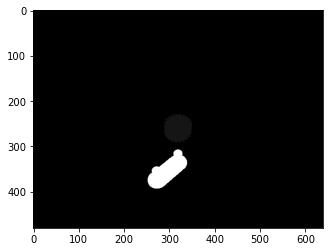

In [18]:
camPos,camTwist, X, Y,Z, cam_euler = calc_params(45,45,0.25)
set_cam_state_gazebo(camPos, camTwist)
cam_world_T = get_camera_extrinsics(45,45,0.25)
resp = get_object_states(n_models)
_,obj_cam_T = get_object2cam_pose(resp, n_models, cam_world_T)
all_points,_ = mesh2pcld(n_models)
mask_list, bin_mask,pixels_list = pcl_2_binary_mask(obj_cam_T, n_models, all_points)

#print(pixels_list[1])
imshow(bin_mask, cmap='gray')
r,c = bin_mask.nonzero()
#print(np.unique(bin_mask[r,c]))

#cv2.imwrite('mask/'+str(sample_num)+'.png',bin_mask)

In [19]:
# main loop
sample_num = 0
for dist in np.arange(0.15,0.5,0.125):
    for phi in range(35,90,15):
        for theta in range(0, 360, 15):
            camPos,camTwist,_,_,_,_ =  calc_params(phi,theta,dist)
            set_cam_state_gazebo(camPos, camTwist)
            
            
            while not rospy.is_shutdown():
                print('Subscribing to camera topics...')
                try:
                    cv_image, cv_depthImage = check_dup()
                    break  
                except ROSException as e:
                        print('Timeout occured in subscribing.Trying again...')
                        continue
            
            cv_depthImage = convert_types(cv_depthImage,0,3, 0,65535, np.uint16) ## 0 - 3m is the input range of kinect depth
            print('Writing Images')
            cv2.imwrite('rgb/'+str(sample_num)+'.png', cv_image)
            cv2.imwrite('depth/'+str(sample_num)+'.png',cv_depthImage)
                    
            try:
                resp = get_object_states(n_models)
            except Exception as inst:
                     print('Error in gazebo/get_link_state service request: ' + str(inst) )
                
            cam_world_T = get_camera_extrinsics(phi,theta,dist)
            gt_dict,obj_cam_T = get_object2cam_pose(resp, n_models,cam_world_T)
            
            sio.savemat('meta/'+str(sample_num)+'-meta.mat',gt_dict)
        
            mask_list, bin_mask,pixels_list = pcl_2_binary_mask(obj_cam_T, n_models, all_points)
            
            cv2.imwrite('mask/'+str(sample_num)+'.png',bin_mask)
            
            sample_num += 1
            

Transforming camera to pose : 0
Subscribing to camera topics...
Subscribing to rgb topics...
Subscribing to depth topics...
Writing Images
left_gear
1
[0.14869139 0.14862528 0.14890899 ... 0.12545311 0.12499428 0.12510608]
[380.54703 379.3902  379.59946 ... 356.88904 357.458   358.0541 ]
bottom_casing
0
[0.11736404 0.11883034 0.11851685 ... 0.10832841 0.10832125 0.10856333]
[529.4569  526.77814 527.7588  ... 509.85007 510.23532 514.1424 ]
Transforming camera to pose : 1
Subscribing to camera topics...
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 1
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 1
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 1
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 1
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 1
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 1
Subscribing t

Transforming camera to pose : 10
Subscribing to camera topics...
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 10
Subscribing to rgb topics...
rgb diff: 6.893001302083333
False
Subscribing to depth topics...
depth diff: -3880.3906
False
Writing Images
bottom_casing
0
[0.16016933 0.15891007 0.1591324  ... 0.17056583 0.17068945 0.17039701]
[119.81836  121.410736 120.754845 ... 134.92555  134.68503  132.17685 ]
left_gear
1
[0.14378199 0.14415835 0.14405842 ... 0.15564239 0.15557717 0.1553225 ]
[265.51797 266.326   266.4393  ... 256.84412 256.00803 255.8228 ]
Transforming camera to pose : 11
Subscribing to camera topics...
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 11
Subscribing to rgb topics...
rgb diff: 6.275625
False
Subscribing to depth topics...
depth diff: -3874.1812
False
Writing Images
bottom_casing
0
[0.17214917 0.17073938 0.1710108  ... 0.18199557 0.18214217 0.18200737]
[150.49142 150.65717 150.32076 ... 172.4947

rgb diff: 0.0
True
Transforming camera to pose : 16
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 16
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 16
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 16
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 16
Subscribing to rgb topics...
rgb diff: 4.809585503472222
False
Subscribing to depth topics...
depth diff: -3879.2725
False
Writing Images
bottom_casing
0
[0.19761795 0.19687153 0.19708532 ... 0.19667688 0.19685043 0.1975442 ]
[355.61115 351.41592 352.1654  ... 392.25656 392.347   390.60757]
left_gear
1
[0.16136165 0.16132127 0.16138633 ... 0.1581543  0.158114   0.1580789 ]
[296.6284  297.77603 296.95996 ... 373.16794 373.86945 373.02005]
Transforming camera to pose : 17
Subscribing to camera topics...
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 17
Subscribing to rgb topics...
rgb dif

rgb diff: 11.018120659722221
False
Subscribing to depth topics...
depth diff: -3896.9846
False
Writing Images
left_gear
1
[0.1487341  0.14873809 0.14901431 ... 0.12709896 0.12661403 0.12667234]
[380.5299  379.34592 379.558   ... 356.42358 356.99088 357.59525]
bottom_casing
0
[0.12436838 0.12552002 0.12527063 ... 0.11715952 0.11719738 0.11746547]
[517.71356 515.80786 516.6086  ... 495.61078 495.8989  499.50067]
Transforming camera to pose : 25
Subscribing to camera topics...
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 25
Subscribing to rgb topics...
rgb diff: 9.179828559027778
False
Subscribing to depth topics...
depth diff: -3477.6235
False
Writing Images
left_gear
1
[0.14609516 0.14615652 0.14641333 ... 0.12622902 0.12573394 0.12576418]
[378.4995  377.11227 377.55188 ... 330.55618 330.6901  331.5219 ]
bottom_casing
0
[0.11789699 0.11901286 0.11875624 ... 0.11213052 0.11215857 0.11228277]
[473.0564  473.68286 473.98026 ... 432.57138 432.75702 436.8337 

rgb diff: 0.0
True
Transforming camera to pose : 35
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 35
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 35
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 35
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 35
Subscribing to rgb topics...
rgb diff: 0.0
True
Transforming camera to pose : 35
Subscribing to rgb topics...
rgb diff: 7.128197699652778
False
Subscribing to depth topics...
depth diff: -3480.2893
False
Writing Images
bottom_casing
0
[0.16739163 0.16628546 0.1664953  ... 0.17500335 0.17516193 0.17513445]
[145.64696 146.09613 145.69334 ... 166.56357 166.39471 163.87914]
left_gear
1
[0.14743586 0.14775096 0.14772479 ... 0.15346925 0.15332682 0.1531066 ]
[261.8462  262.9234  262.82214 ... 272.08136 271.42654 271.04803]
Transforming camera to pose : 36
Subscribing to camera topics...
Subscribing to rgb topics...
rgb dif

KeyboardInterrupt: 